# Importation des bibliothèques nécessaires


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import LinearSVC
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import os
import warnings
import sklearn
from gensim.models import Word2Vec
import torch  # Ajout de torch pour BERT et deep learning

# Suppress all warnings and specifically scikit-learn warnings for cleaner output
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=sklearn.exceptions.ConvergenceWarning)

# Chargement des jeux de données

In [6]:
liar_dir = '../data/LIAR'
fakenewsnet_dir = '../data/FAKENEWSNET'

# Chargement du jeu de données LIAR
liar_train = pd.read_csv(os.path.join(liar_dir, 'train.tsv'), sep='\t', header=None)
liar_valid = pd.read_csv(os.path.join(liar_dir, 'valid.tsv'), sep='\t', header=None)
liar_test = pd.read_csv(os.path.join(liar_dir, 'test.tsv'), sep='\t', header=None)

print('LIAR train.tsv head:')
print(liar_train.head())
print('\nLIAR valid.tsv head:')
print(liar_valid.head())
print('\nLIAR test.tsv head:')
print(liar_test.head())

# Chargement du jeu de données FakeNewsNet (BuzzFeed)
buzz_fake = pd.read_csv(os.path.join(fakenewsnet_dir, 'BuzzFeed_fake_news_content.csv'))
buzz_real = pd.read_csv(os.path.join(fakenewsnet_dir, 'BuzzFeed_real_news_content.csv'))

# Ajout des labels et concaténation
def prepare_buzzfeed(buzz_fake, buzz_real):
    buzz_fake['label'] = 'fake'
    buzz_real['label'] = 'real'
    buzz_all = pd.concat([buzz_fake, buzz_real], ignore_index=True)
    return buzz_all

buzz_all = prepare_buzzfeed(buzz_fake, buzz_real)

print('\nBuzzFeed_fake_news_content.csv head:')
print(buzz_fake.head())
print('\nBuzzFeed_real_news_content.csv head:')
print(buzz_real.head())
print('\nBuzzFeed (all) head:')
print(buzz_all.head())

LIAR train.tsv head:
           0            1                                                  2   \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                                   3               4                     5   \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jobs   charlie-crist                   NaN   

         6       

# Prétraitement des textes : étape par étape
Nous allons visualiser l'effet de chaque étape du prétraitement sur un exemple du jeu LIAR et du jeu BuzzFeed. À la fin, nous comparerons le texte original, le texte après toutes les étapes de prétraitement, et le texte sans aucun prétraitement.

In [7]:
ps = PorterStemmer()
wst = WhitespaceTokenizer()

sample_text = liar_train.iloc[0, 2] if liar_train.shape[0] > 0 else ''
sample_buzz = buzz_all['text'].iloc[0] if 'text' in buzz_all.columns and buzz_all.shape[0] > 0 else ''

print('--- LIAR Example ---')
print('Original:', sample_text)

# 1. Converting text to lower case
def lower_func(x):
    return x.lower()
liar_lower = lower_func(sample_text)
print('Lowercase:', liar_lower)

# 2. Removing Numbers from the text corpus
def remove_number_func(x):
    return ''.join([a for a in x if not a.isdigit()])
liar_no_num = remove_number_func(liar_lower)
print('No numbers:', liar_no_num)

# 3. Removing punctuation
def remove_punc_func(x):
    return ''.join([a for a in x if a not in string.punctuation])
liar_no_punc = remove_punc_func(liar_no_num)
print('No punctuation:', liar_no_punc)

# 4. Removing special characters
def remove_spec_char_func(x):
    return ''.join([a for a in x if a.isalnum() or a == ' '])
liar_no_spec = remove_spec_char_func(liar_no_punc)
print('No special chars:', liar_no_spec)

# 5. Removing english stopwords
def remove_stopwords(x):
    return ' '.join([a for a in x.split() if a not in stopwords.words('english')])
liar_no_stop = remove_stopwords(liar_no_spec)
print('No stopwords:', liar_no_stop)

# 6. Removing extra whitespaces
def remove_whitespace_func(x):
    return ' '.join(wst.tokenize(x))
liar_no_ws = remove_whitespace_func(liar_no_stop)
print('No extra whitespaces:', liar_no_ws)

# 7. Stemming words to root words (last step)
def stem_func(x):
    wordlist = word_tokenize(x)
    psstem = [ps.stem(a) for a in wordlist]
    return ' '.join(psstem)
liar_final = stem_func(liar_no_ws)
print('Stemming:', liar_final)

print('\n--- BuzzFeed Example (first 15 words only) ---')
def show_first_words(text, n=15):
    return ' '.join(text.split()[:n])

print('Original:', show_first_words(sample_buzz))
buzz_lower = lower_func(sample_buzz)
print('Lowercase:', show_first_words(buzz_lower))
buzz_no_num = remove_number_func(buzz_lower)
print('No numbers:', show_first_words(buzz_no_num))
buzz_no_punc = remove_punc_func(buzz_no_num)
print('No punctuation:', show_first_words(buzz_no_punc))
buzz_no_spec = remove_spec_char_func(buzz_no_punc)
print('No special chars:', show_first_words(buzz_no_spec))
buzz_no_stop = remove_stopwords(buzz_no_spec)
print('No stopwords:', show_first_words(buzz_no_stop))
buzz_no_ws = remove_whitespace_func(buzz_no_stop)
print('No extra whitespaces:', show_first_words(buzz_no_ws))
buzz_final = stem_func(buzz_no_ws)
print('Stemming:', show_first_words(buzz_final))

# Visualisation : original vs. full preprocessing vs. no preprocessing
print('\n--- Résumé LIAR ---')
print('Original:', sample_text)
print('Full preprocessing:', liar_final)
print('No preprocessing:', sample_text)

print('\n--- Résumé BuzzFeed (first 15 words only) ---')
print('Original:', show_first_words(sample_buzz))
print('Full preprocessing:', show_first_words(buzz_final))
print('No preprocessing:', show_first_words(sample_buzz))

--- LIAR Example ---
Original: Says the Annies List political group supports third-trimester abortions on demand.
Lowercase: says the annies list political group supports third-trimester abortions on demand.
No numbers: says the annies list political group supports third-trimester abortions on demand.
No punctuation: says the annies list political group supports thirdtrimester abortions on demand
No special chars: says the annies list political group supports thirdtrimester abortions on demand
No stopwords: says annies list political group supports thirdtrimester abortions demand
No extra whitespaces: says annies list political group supports thirdtrimester abortions demand
Stemming: say anni list polit group support thirdtrimest abort demand

--- BuzzFeed Example (first 15 words only) ---
Original: I woke up this morning to find a variation of this headline splashed all over
Lowercase: i woke up this morning to find a variation of this headline splashed all over
No numbers: i woke up 

# Encodage des textes : TF-IDF, Word2Vec
- TF-IDF (Term Frequency-Inverse Document Frequency)
- Word2Vec (représentation vectorielle continue)
Pour chaque méthode, nous illustrons l'encodage sur un sous-ensemble des données prétraitées.

In [8]:

# Prétraitement minimal pour l'encodage (sans stemming, pour l'exemple)
liar_train['text_clean'] = liar_train[2].astype(str).apply(lambda x: remove_whitespace_func(remove_stopwords(remove_spec_char_func(remove_punc_func(remove_number_func(lower_func(x)))))))
buzz_all['text_clean'] = buzz_all['text'].astype(str).apply(lambda x: remove_whitespace_func(remove_stopwords(remove_spec_char_func(remove_punc_func(remove_number_func(lower_func(x)))))))

# 1. TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer(max_features=20)
X_liar_tfidf = vectorizer_tfidf.fit_transform(liar_train['text_clean'])
print('TF-IDF features (LIAR):', vectorizer_tfidf.get_feature_names_out())
print('TF-IDF vector (first sample):', X_liar_tfidf[0].toarray())

vectorizer_tfidf_buzz = TfidfVectorizer(max_features=20)
X_buzz_tfidf = vectorizer_tfidf_buzz.fit_transform(buzz_all['text_clean'])
print('TF-IDF features (BuzzFeed):', vectorizer_tfidf_buzz.get_feature_names_out())
print('TF-IDF vector (first sample):', X_buzz_tfidf[0].toarray())

# 2. Word2Vec (illustration sur un sous-ensemble)
from gensim.models import Word2Vec
liar_sentences = liar_train['text_clean'].apply(lambda x: x.split()).tolist()[:1000]
buzz_sentences = buzz_all['text_clean'].apply(lambda x: x.split()).tolist()[:1000]

w2v_liar = Word2Vec(sentences=liar_sentences, vector_size=50, window=5, min_count=1, workers=2)
w2v_buzz = Word2Vec(sentences=buzz_sentences, vector_size=50, window=5, min_count=1, workers=2)

print('Word2Vec vector for "truth":', w2v_liar.wv['truth'] if 'truth' in w2v_liar.wv else 'Not in vocab')
print('Word2Vec vector for "news":', w2v_buzz.wv['news'] if 'news' in w2v_buzz.wv else 'Not in vocab')

TF-IDF features (LIAR): ['bill' 'billion' 'care' 'health' 'jobs' 'million' 'new' 'obama' 'one'
 'people' 'percent' 'president' 'says' 'state' 'states' 'tax' 'us' 'would'
 'year' 'years']
TF-IDF vector (first sample): [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
TF-IDF features (BuzzFeed): ['also' 'campaign' 'clinton' 'debate' 'donald' 'even' 'first' 'get'
 'hillary' 'know' 'like' 'new' 'obama' 'one' 'people' 'president' 'said'
 'trump' 'us' 'would']
TF-IDF vector (first sample): [[0.12817395 0.08095653 0.59983131 0.         0.13241785 0.
  0.         0.06987181 0.06450198 0.         0.20398866 0.06939416
  0.         0.         0.23772557 0.         0.0576483  0.6959735
  0.         0.        ]]
Bag of Words features (LIAR): ['bill' 'billion' 'care' 'health' 'jobs' 'million' 'new' 'obama' 'one'
 'people' 'percent' 'president' 'says' 'state' 'states' 'tax' 'us' 'would'
 'year' 'years']
Bag of Words vector (first sample): [[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]
Bag

## Feature Engineering : Text Length, Chi-square, and Information Gain


In [16]:
# --- Ajout de la longueur du texte comme feature ---
liar_train['text_length'] = liar_train[2].astype(str).apply(len)
print('Exemple de longueur de texte (LIAR):')
print(liar_train[['text_length', 2]].head())

# --- Sélection de features : Chi-square et Information Gain ---
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# Utilisation de TF-IDF pour la sélection de features
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(liar_train['text_clean'])

# Encodage des labels (true/fake)
le = LabelEncoder()
y = le.fit_transform(liar_train[1])

# Chi-square
chi2_scores, chi2_p = chi2(X_tfidf, y)
chi2_features = pd.Series(chi2_scores, index=vectorizer.get_feature_names_out()).sort_values(ascending=False)
print('Top 10 features (chi-square):')
print(chi2_features.head(10))

# Information Gain (Mutual Information)
mi_scores = mutual_info_classif(X_tfidf, y, discrete_features=True)
mi_features = pd.Series(mi_scores, index=vectorizer.get_feature_names_out()).sort_values(ascending=False)
print('Top 10 features (information gain):')
print(mi_features.head(10))

Exemple de longueur de texte (LIAR):
   text_length                                                  2
0           82  Says the Annies List political group supports ...
1          141  When did the decline of coal start? It started...
2          105  Hillary Clinton agrees with John McCain "by vo...
3           78  Health care reform legislation is likely to ma...
4           54  The economic turnaround started at the end of ...
Top 10 features (chi-square):
obama        27.291409
muslim       24.812940
percent      24.215940
barack       21.477176
obamacare    18.010508
since        15.235563
highest      14.468923
rep          14.117115
half         13.494195
average      12.398935
dtype: float64
Top 10 features (information gain):
says         0.402139
percent      0.165593
state        0.125158
obama        0.121612
tax          0.102647
years        0.097009
people       0.095986
president    0.094909
health       0.091845
states       0.089578
dtype: float64


## Visualisation des features : longueur des textes et importance des mots


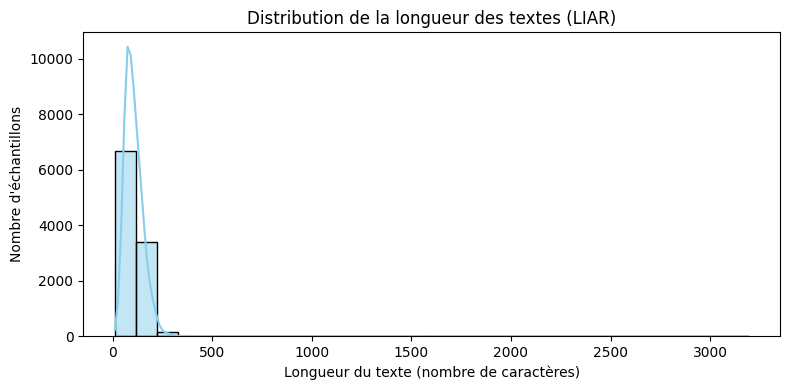

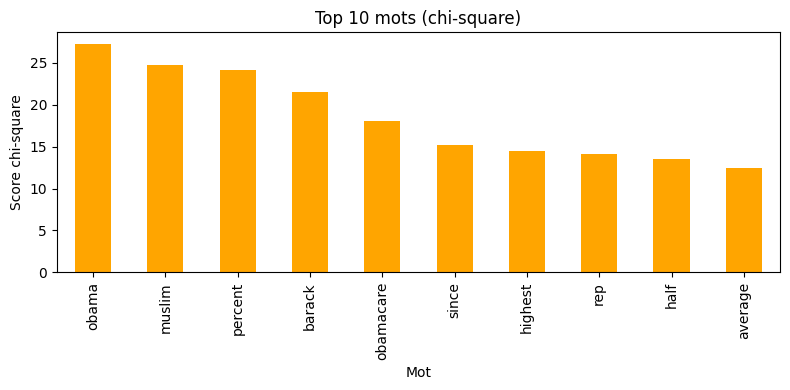

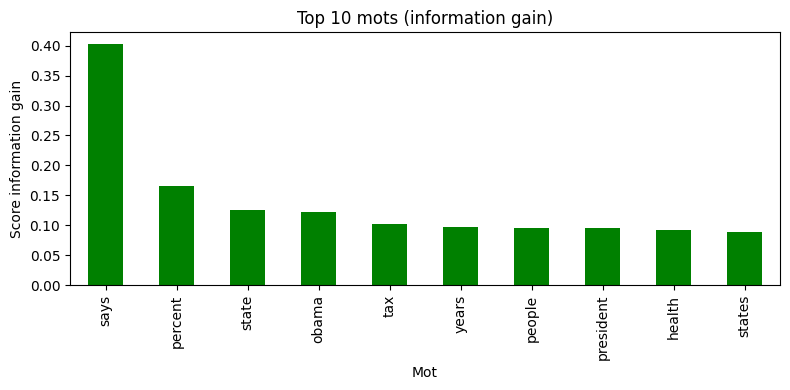

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution de la longueur des textes
plt.figure(figsize=(8, 4))
sns.histplot(liar_train['text_length'], bins=30, kde=True, color='skyblue')
plt.title('Distribution de la longueur des textes (LIAR)')
plt.xlabel('Longueur du texte (nombre de caractères)')
plt.ylabel('Nombre d\'échantillons')
plt.tight_layout()
plt.show()

# 2. Top 10 features par chi-square
plt.figure(figsize=(8, 4))
chi2_features.head(10).plot(kind='bar', color='orange')
plt.title('Top 10 mots (chi-square)')
plt.ylabel('Score chi-square')
plt.xlabel('Mot')
plt.tight_layout()
plt.show()

# 3. Top 10 features par information gain
plt.figure(figsize=(8, 4))
mi_features.head(10).plot(kind='bar', color='green')
plt.title('Top 10 mots (information gain)')
plt.ylabel('Score information gain')
plt.xlabel('Mot')
plt.tight_layout()
plt.show()

Exemple de longueur de texte (BuzzFeed):
   text_length                                               text
0         3218  I woke up this morning to find a variation of ...
1         8837  Former President Bill Clinton and his Clinton ...
2         3471  After collapsing just before trying to step in...
3         4454  Donald Trump is, well, deplorable. He’s sugges...
4           31                    Website is Down For Maintenance
Top 10 features (chi-square) BuzzFeed:
highlights    1.754566
trump         1.743970
wednesday     1.663752
border        1.597866
muslim        1.549363
monday        1.438092
conway        1.370738
johnson       1.327873
hillary       1.266541
said          1.252133
dtype: float64
Top 10 features (information gain) BuzzFeed:
said       0.418639
people     0.393982
one        0.391910
trump      0.365420
also       0.346845
would      0.346604
donald     0.344191
hillary    0.342885
clinton    0.326020
like       0.317699
dtype: float64


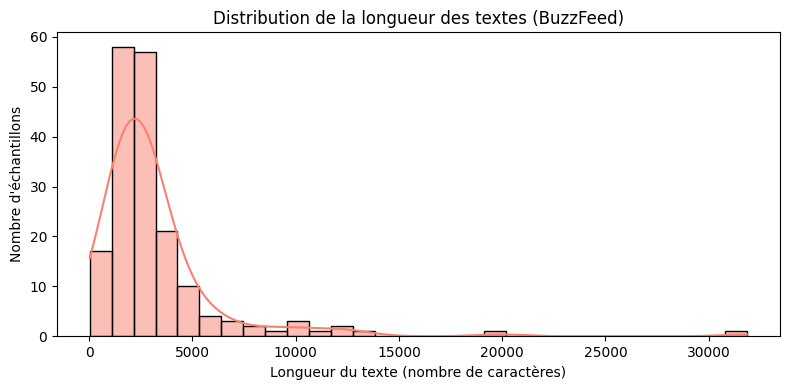

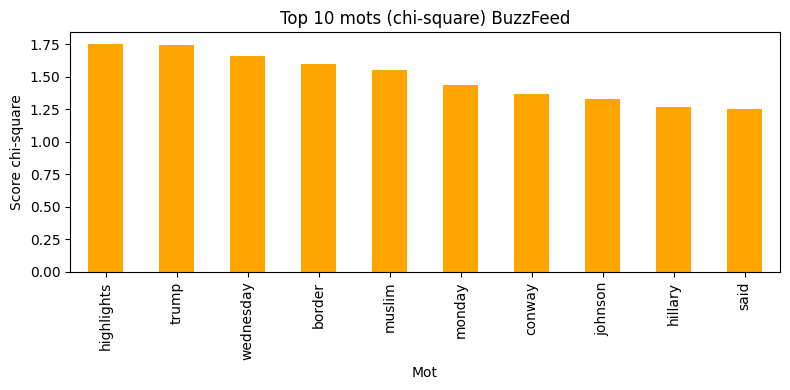

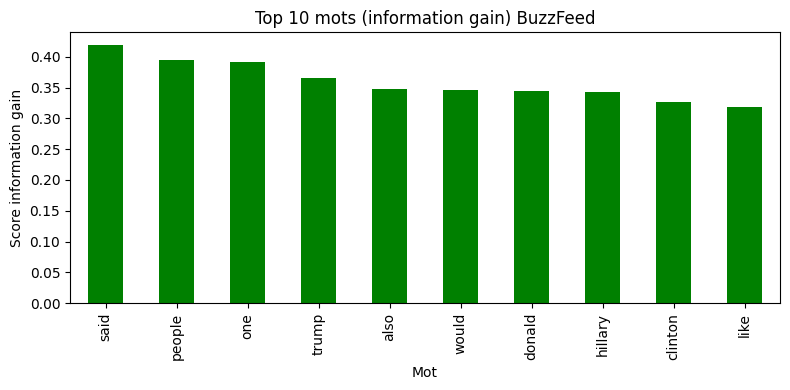

In [9]:
# --- Ajout de la longueur du texte comme feature pour BuzzFeed ---
buzz_all['text_length'] = buzz_all['text'].astype(str).apply(len)
print('Exemple de longueur de texte (BuzzFeed):')
print(buzz_all[['text_length', 'text']].head())

# --- Sélection de features : Chi-square et Information Gain pour BuzzFeed ---
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# Utilisation de TF-IDF pour la sélection de features
vectorizer_buzz = TfidfVectorizer(max_features=1000)
X_tfidf_buzz = vectorizer_buzz.fit_transform(buzz_all['text_clean'])

# Encodage des labels (real/fake)
le_buzz = LabelEncoder()
y_buzz = le_buzz.fit_transform(buzz_all['label'])

# Chi-square
chi2_scores_buzz, chi2_p_buzz = chi2(X_tfidf_buzz, y_buzz)
chi2_features_buzz = pd.Series(chi2_scores_buzz, index=vectorizer_buzz.get_feature_names_out()).sort_values(ascending=False)
print('Top 10 features (chi-square) BuzzFeed:')
print(chi2_features_buzz.head(10))

# Information Gain (Mutual Information)
mi_scores_buzz = mutual_info_classif(X_tfidf_buzz, y_buzz, discrete_features=True)
mi_features_buzz = pd.Series(mi_scores_buzz, index=vectorizer_buzz.get_feature_names_out()).sort_values(ascending=False)
print('Top 10 features (information gain) BuzzFeed:')
print(mi_features_buzz.head(10))

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution de la longueur des textes BuzzFeed
plt.figure(figsize=(8, 4))
sns.histplot(buzz_all['text_length'], bins=30, kde=True, color='salmon')
plt.title('Distribution de la longueur des textes (BuzzFeed)')
plt.xlabel('Longueur du texte (nombre de caractères)')
plt.ylabel('Nombre d\'échantillons')
plt.tight_layout()
plt.show()

# 2. Top 10 features par chi-square BuzzFeed
plt.figure(figsize=(8, 4))
chi2_features_buzz.head(10).plot(kind='bar', color='orange')
plt.title('Top 10 mots (chi-square) BuzzFeed')
plt.ylabel('Score chi-square')
plt.xlabel('Mot')
plt.tight_layout()
plt.show()

# 3. Top 10 features par information gain BuzzFeed
plt.figure(figsize=(8, 4))
mi_features_buzz.head(10).plot(kind='bar', color='green')
plt.title('Top 10 mots (information gain) BuzzFeed')
plt.ylabel('Score information gain')
plt.xlabel('Mot')
plt.tight_layout()
plt.show()

# Analyse de la fréquence des mots dans les textes des fake news et real news


In [1]:
# Définir la fonction de prétraitement finale (avec stemming)
def final(text):
    x = lower_func(text)
    x = remove_number_func(x)
    x = remove_punc_func(x)
    x = remove_spec_char_func(x)
    x = remove_stopwords(x)
    x = remove_whitespace_func(x)
    x = stem_func(x)
    return x

# --- LIAR dataset ---
liar_train['text_final'] = liar_train[2].astype(str).apply(final)
liar_fake = liar_train[liar_train[1] == 'false']
liar_real = liar_train[liar_train[1] == 'true']

cv_liar_fake = CountVectorizer()
cv_liar_fake.fit(liar_fake['text_final'])
bow_liar_fake = cv_liar_fake.transform(liar_fake['text_final'])
words_liar_fake = cv_liar_fake.get_feature_names_out()
matrix_liar_fake = pd.DataFrame(bow_liar_fake.todense(), columns=words_liar_fake)
sum_liar_fake = matrix_liar_fake.sum(axis=0)
top_liar_fake = sum_liar_fake.sort_values(ascending=False).head(30)

cv_liar_real = CountVectorizer()
cv_liar_real.fit(liar_real['text_final'])
bow_liar_real = cv_liar_real.transform(liar_real['text_final'])
words_liar_real = cv_liar_real.get_feature_names_out()
matrix_liar_real = pd.DataFrame(bow_liar_real.todense(), columns=words_liar_real)
sum_liar_real = matrix_liar_real.sum(axis=0)
top_liar_real = sum_liar_real.sort_values(ascending=False).head(30)

# --- BuzzFeed dataset ---
buzz_fake = buzz_all[buzz_all['label'] == 'fake']
buzz_real = buzz_all[buzz_all['label'] == 'real']
buzz_fake['text_final'] = buzz_fake['text'].astype(str).apply(final)
buzz_real['text_final'] = buzz_real['text'].astype(str).apply(final)

cv_buzz_fake = CountVectorizer()
cv_buzz_fake.fit(buzz_fake['text_final'])
bow_buzz_fake = cv_buzz_fake.transform(buzz_fake['text_final'])
words_buzz_fake = cv_buzz_fake.get_feature_names_out()
matrix_buzz_fake = pd.DataFrame(bow_buzz_fake.todense(), columns=words_buzz_fake)
sum_buzz_fake = matrix_buzz_fake.sum(axis=0)
top_buzz_fake = sum_buzz_fake.sort_values(ascending=False).head(30)

cv_buzz_real = CountVectorizer()
cv_buzz_real.fit(buzz_real['text_final'])
bow_buzz_real = cv_buzz_real.transform(buzz_real['text_final'])
words_buzz_real = cv_buzz_real.get_feature_names_out()
matrix_buzz_real = pd.DataFrame(bow_buzz_real.todense(), columns=words_buzz_real)
sum_buzz_real = matrix_buzz_real.sum(axis=0)
top_buzz_real = sum_buzz_real.sort_values(ascending=False).head(30)

# Préparer les DataFrames pour la visualisation
liar_fake_df = pd.DataFrame({'word': top_liar_fake.index, 'sum': top_liar_fake.values, 'type': ['Fake']*30})
liar_real_df = pd.DataFrame({'word': top_liar_real.index, 'sum': top_liar_real.values, 'type': ['Real']*30})
liar_concat = pd.concat([liar_fake_df, liar_real_df])

buzz_fake_df = pd.DataFrame({'word': top_buzz_fake.index, 'sum': top_buzz_fake.values, 'type': ['Fake']*30})
buzz_real_df = pd.DataFrame({'word': top_buzz_real.index, 'sum': top_buzz_real.values, 'type': ['Real']*30})
buzz_concat = pd.concat([buzz_fake_df, buzz_real_df])

# --- Plotting ---
plt.figure(figsize=(14, 8))
sns.barplot(y='word', x='sum', data=liar_concat, hue='type', palette='viridis')
plt.xlabel('Fréquence des mots', fontsize=12)
plt.ylabel('Top mots dans LIAR', fontsize=12)
plt.title('Top 30 mots les plus fréquents dans les fake news et real news (LIAR)', fontsize=16)
plt.legend(title='Type de news', fontsize=12, loc='lower right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(y='word', x='sum', data=buzz_concat, hue='type', palette='viridis')
plt.xlabel('Fréquence des mots', fontsize=12)
plt.ylabel('Top mots dans BuzzFeed', fontsize=12)
plt.title('Top 30 mots les plus fréquents dans les fake news et real news (BuzzFeed)', fontsize=16)
plt.legend(title='Type de news', fontsize=12, loc='lower right')
plt.tight_layout()
plt.show()

NameError: name 'liar_train' is not defined

## Machine learning Models : TF-IDF + Random Forest

In [1]:
# --- TF-IDF + Random Forest : Texte brut, prétraité sans stemming, prétraité avec stemming (LIAR et BuzzFeed) ---

from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

# === LIAR DATASET (utiliser les splits officiels) ===
liar_X_train = liar_train[2].astype(str)
liar_y_train = liar_train[1].astype(str)
liar_X_test = liar_test[2].astype(str)
liar_y_test = liar_test[1].astype(str)

# 1. Texte brut
vectorizer_liar_raw = TfidfVectorizer(max_features=1000)
X_liar_raw_train = vectorizer_liar_raw.fit_transform(liar_X_train)
X_liar_raw_test = vectorizer_liar_raw.transform(liar_X_test)
rf_liar_raw = RandomForestClassifier(random_state=42)
rf_liar_raw.fit(X_liar_raw_train, liar_y_train)
y_pred_liar_raw = rf_liar_raw.predict(X_liar_raw_test)
print('LIAR (Raw Text, Test Set) - Random Forest')
print('Accuracy:', accuracy_score(liar_y_test, y_pred_liar_raw))
print('Recall:', recall_score(liar_y_test, y_pred_liar_raw, average="macro"))
print('F1-score:', f1_score(liar_y_test, y_pred_liar_raw, average="macro"))

# 2. Texte prétraité sans stemming
def preprocess_no_stem(text):
    x = lower_func(text)
    x = remove_number_func(x)
    x = remove_punc_func(x)
    x = remove_spec_char_func(x)
    x = remove_stopwords(x)
    x = remove_whitespace_func(x)
    return x

if 'text_nostem' not in liar_train.columns:
    liar_train['text_nostem'] = liar_train[2].astype(str).apply(preprocess_no_stem)
    liar_test['text_nostem'] = liar_test[2].astype(str).apply(preprocess_no_stem)
elif 'text_nostem' not in liar_test.columns:
    liar_test['text_nostem'] = liar_test[2].astype(str).apply(preprocess_no_stem)

vectorizer_liar_nostem = TfidfVectorizer(max_features=1000)
X_liar_nostem_train = vectorizer_liar_nostem.fit_transform(liar_train['text_nostem'])
X_liar_nostem_test = vectorizer_liar_nostem.transform(liar_test['text_nostem'])
rf_liar_nostem = RandomForestClassifier(random_state=42)
rf_liar_nostem.fit(X_liar_nostem_train, liar_y_train)
y_pred_liar_nostem = rf_liar_nostem.predict(X_liar_nostem_test)
print('\nLIAR (Preprocessed No Stemming, Test Set) - Random Forest')
print('Accuracy:', accuracy_score(liar_y_test, y_pred_liar_nostem))
print('Recall:', recall_score(liar_y_test, y_pred_liar_nostem, average="macro"))
print('F1-score:', f1_score(liar_y_test, y_pred_liar_nostem, average="macro"))

# 3. Texte prétraité avec stemming
def preprocess_with_stem(text):
    x = lower_func(text)
    x = remove_number_func(x)
    x = remove_punc_func(x)
    x = remove_spec_char_func(x)
    x = remove_stopwords(x)
    x = remove_whitespace_func(x)
    x = stem_func(x)
    return x

if 'text_final' not in liar_train.columns:
    liar_train['text_final'] = liar_train[2].astype(str).apply(preprocess_with_stem)
    liar_test['text_final'] = liar_test[2].astype(str).apply(preprocess_with_stem)
elif 'text_final' not in liar_test.columns:
    liar_test['text_final'] = liar_test[2].astype(str).apply(preprocess_with_stem)

vectorizer_liar_final = TfidfVectorizer(max_features=1000)
X_liar_final_train = vectorizer_liar_final.fit_transform(liar_train['text_final'])
X_liar_final_test = vectorizer_liar_final.transform(liar_test['text_final'])
rf_liar_final = RandomForestClassifier(random_state=42)
rf_liar_final.fit(X_liar_final_train, liar_y_train)
y_pred_liar_final = rf_liar_final.predict(X_liar_final_test)
print('\nLIAR (Preprocessed With Stemming, Test Set) - Random Forest')
print('Accuracy:', accuracy_score(liar_y_test, y_pred_liar_final))
print('Recall:', recall_score(liar_y_test, y_pred_liar_final, average="macro"))
print('F1-score:', f1_score(liar_y_test, y_pred_liar_final, average="macro"))

# === BUZZFEED DATASET (split 70/30) ===
from sklearn.model_selection import train_test_split

buzz_X = buzz_all['text'].astype(str)
buzz_y = buzz_all['label'].astype(str)
buzz_X_train, buzz_X_test, buzz_y_train, buzz_y_test = train_test_split(
    buzz_X, buzz_y, test_size=0.3, random_state=42, stratify=buzz_y
)


# 1. Texte brut
vectorizer_buzz_raw = TfidfVectorizer(max_features=1000)
X_buzz_raw_train = vectorizer_buzz_raw.fit_transform(buzz_X_train)
X_buzz_raw_test = vectorizer_buzz_raw.transform(buzz_X_test)
rf_buzz_raw = RandomForestClassifier(random_state=42)
rf_buzz_raw.fit(X_buzz_raw_train, buzz_y_train)
y_pred_buzz_raw = rf_buzz_raw.predict(X_buzz_raw_test)
print('\nBuzzFeed (Raw Text) - Random Forest')
print('Accuracy:', accuracy_score(buzz_y_test, y_pred_buzz_raw))
print('Recall:', recall_score(buzz_y_test, y_pred_buzz_raw, average="macro"))
print('F1-score:', f1_score(buzz_y_test, y_pred_buzz_raw, average="macro"))

# 2. Texte prétraité sans stemming
if 'text_nostem' not in buzz_all.columns:
    buzz_all['text_nostem'] = buzz_all['text'].astype(str).apply(preprocess_no_stem)

buzz_nostem_train = buzz_all.loc[buzz_X_train.index, 'text_nostem']
buzz_nostem_test = buzz_all.loc[buzz_X_test.index, 'text_nostem']

vectorizer_buzz_nostem = TfidfVectorizer(max_features=1000)
X_buzz_nostem_train = vectorizer_buzz_nostem.fit_transform(buzz_nostem_train)
X_buzz_nostem_test = vectorizer_buzz_nostem.transform(buzz_nostem_test)
rf_buzz_nostem = RandomForestClassifier(random_state=42)
rf_buzz_nostem.fit(X_buzz_nostem_train, buzz_y_train)
y_pred_buzz_nostem = rf_buzz_nostem.predict(X_buzz_nostem_test)
print('\nBuzzFeed (Preprocessed No Stemming) - Random Forest')
print('Accuracy:', accuracy_score(buzz_y_test, y_pred_buzz_nostem))
print('Recall:', recall_score(buzz_y_test, y_pred_buzz_nostem, average="macro"))
print('F1-score:', f1_score(buzz_y_test, y_pred_buzz_nostem, average="macro"))

# 3. Texte prétraité avec stemming
if 'text_final' not in buzz_all.columns:
    buzz_all['text_final'] = buzz_all['text'].astype(str).apply(preprocess_with_stem)

buzz_final_train = buzz_all.loc[buzz_X_train.index, 'text_final']
buzz_final_test = buzz_all.loc[buzz_X_test.index, 'text_final']

vectorizer_buzz_final = TfidfVectorizer(max_features=1000)
X_buzz_final_train = vectorizer_buzz_final.fit_transform(buzz_final_train)
X_buzz_final_test = vectorizer_buzz_final.transform(buzz_final_test)
rf_buzz_final = RandomForestClassifier(random_state=42)
rf_buzz_final.fit(X_buzz_final_train, buzz_y_train)
y_pred_buzz_final = rf_buzz_final.predict(X_buzz_final_test)
print('\nBuzzFeed (Preprocessed With Stemming) - Random Forest')
print('Accuracy:', accuracy_score(buzz_y_test, y_pred_buzz_final))
print('Recall:', recall_score(buzz_y_test, y_pred_buzz_final, average="macro"))
print('F1-score:', f1_score(buzz_y_test, y_pred_buzz_final, average="macro"))

NameError: name 'liar_train' is not defined

## TF-IDF + Naive Bayes

In [29]:
# --- TF-IDF + Naive Bayes : Texte brut, prétraité sans stemming, prétraité avec stemming (LIAR et BuzzFeed) ---
from sklearn.naive_bayes import MultinomialNB

# === LIAR DATASET (utiliser les splits officiels) ===
# 1. Texte brut
nb_liar_raw = MultinomialNB()
nb_liar_raw.fit(X_liar_raw_train, liar_y_train)
y_pred_liar_nb_raw = nb_liar_raw.predict(X_liar_raw_test)
print('\nLIAR (Raw Text, Test Set) - Naive Bayes')
print('Accuracy:', accuracy_score(liar_y_test, y_pred_liar_nb_raw))
print('Recall:', recall_score(liar_y_test, y_pred_liar_nb_raw, average="macro"))
print('F1-score:', f1_score(liar_y_test, y_pred_liar_nb_raw, average="macro"))

# 2. Texte prétraité sans stemming
nb_liar_nostem = MultinomialNB()
nb_liar_nostem.fit(X_liar_nostem_train, liar_y_train)
y_pred_liar_nb_nostem = nb_liar_nostem.predict(X_liar_nostem_test)
print('\nLIAR (Preprocessed No Stemming, Test Set) - Naive Bayes')
print('Accuracy:', accuracy_score(liar_y_test, y_pred_liar_nb_nostem))
print('Recall:', recall_score(liar_y_test, y_pred_liar_nb_nostem, average="macro"))
print('F1-score:', f1_score(liar_y_test, y_pred_liar_nb_nostem, average="macro"))

# 3. Texte prétraité avec stemming
nb_liar_final = MultinomialNB()
nb_liar_final.fit(X_liar_final_train, liar_y_train)
y_pred_liar_nb_final = nb_liar_final.predict(X_liar_final_test)
print('\nLIAR (Preprocessed With Stemming, Test Set) - Naive Bayes')
print('Accuracy:', accuracy_score(liar_y_test, y_pred_liar_nb_final))
print('Recall:', recall_score(liar_y_test, y_pred_liar_nb_final, average="macro"))
print('F1-score:', f1_score(liar_y_test, y_pred_liar_nb_final, average="macro"))

# === BUZZFEED DATASET (split 70/30) ===
# 1. Texte brut
nb_buzz_raw = MultinomialNB()
nb_buzz_raw.fit(X_buzz_raw_train, buzz_y_train)
y_pred_buzz_nb_raw = nb_buzz_raw.predict(X_buzz_raw_test)
print('\nBuzzFeed (Raw Text) - Naive Bayes')
print('Accuracy:', accuracy_score(buzz_y_test, y_pred_buzz_nb_raw))
print('Recall:', recall_score(buzz_y_test, y_pred_buzz_nb_raw, average="macro"))
print('F1-score:', f1_score(buzz_y_test, y_pred_buzz_nb_raw, average="macro"))

# 2. Texte prétraité sans stemming
nb_buzz_nostem = MultinomialNB()
nb_buzz_nostem.fit(X_buzz_nostem_train, buzz_y_train)
y_pred_buzz_nb_nostem = nb_buzz_nostem.predict(X_buzz_nostem_test)
print('\nBuzzFeed (Preprocessed No Stemming) - Naive Bayes')
print('Accuracy:', accuracy_score(buzz_y_test, y_pred_buzz_nb_nostem))
print('Recall:', recall_score(buzz_y_test, y_pred_buzz_nb_nostem, average="macro"))
print('F1-score:', f1_score(buzz_y_test, y_pred_buzz_nb_nostem, average="macro"))

# 3. Texte prétraité avec stemming
nb_buzz_final = MultinomialNB()
nb_buzz_final.fit(X_buzz_final_train, buzz_y_train)
y_pred_buzz_nb_final = nb_buzz_final.predict(X_buzz_final_test)
print('\nBuzzFeed (Preprocessed With Stemming) - Naive Bayes')
print('Accuracy:', accuracy_score(buzz_y_test, y_pred_buzz_nb_final))
print('Recall:', recall_score(buzz_y_test, y_pred_buzz_nb_final, average="macro"))
print('F1-score:', f1_score(buzz_y_test, y_pred_buzz_nb_final, average="macro"))


LIAR (Raw Text, Test Set) - Naive Bayes
Accuracy: 0.23993685872138912
Recall: 0.2109196393309947
F1-score: 0.20266224715149447

LIAR (Preprocessed No Stemming, Test Set) - Naive Bayes
Accuracy: 0.2549329123914759
Recall: 0.22254847952455578
F1-score: 0.21174687342485124

LIAR (Preprocessed With Stemming, Test Set) - Naive Bayes
Accuracy: 0.2509865824782952
Recall: 0.21804283149254752
F1-score: 0.20439662122245014

BuzzFeed (Raw Text) - Naive Bayes
Accuracy: 0.7636363636363637
Recall: 0.7665343915343915
F1-score: 0.7585275244849713

BuzzFeed (Preprocessed No Stemming) - Naive Bayes
Accuracy: 0.7454545454545455
Recall: 0.7486772486772486
F1-score: 0.7384510869565217

BuzzFeed (Preprocessed With Stemming) - Naive Bayes
Accuracy: 0.7272727272727273
Recall: 0.7301587301587301
F1-score: 0.7213779128672746


## TF-IDF + SVM

In [31]:
# --- TF-IDF + SVM : Texte brut, prétraité sans stemming, prétraité avec stemming (LIAR et BuzzFeed) ---
from sklearn.svm import LinearSVC

# === LIAR DATASET (utiliser les splits officiels) ===
# 1. Texte brut
svm_liar_raw = LinearSVC(random_state=42, max_iter=10000)
svm_liar_raw.fit(X_liar_raw_train, liar_y_train)
y_pred_liar_svm_raw = svm_liar_raw.predict(X_liar_raw_test)
print('\nLIAR (Raw Text, Test Set) - SVM')
print('Accuracy:', accuracy_score(liar_y_test, y_pred_liar_svm_raw))
print('Recall:', recall_score(liar_y_test, y_pred_liar_svm_raw, average="macro"))
print('F1-score:', f1_score(liar_y_test, y_pred_liar_svm_raw, average="macro"))

# 2. Texte prétraité sans stemming
svm_liar_nostem = LinearSVC(random_state=42, max_iter=10000)
svm_liar_nostem.fit(X_liar_nostem_train, liar_y_train)
y_pred_liar_svm_nostem = svm_liar_nostem.predict(X_liar_nostem_test)
print('\nLIAR (Preprocessed No Stemming, Test Set) - SVM')
print('Accuracy:', accuracy_score(liar_y_test, y_pred_liar_svm_nostem))
print('Recall:', recall_score(liar_y_test, y_pred_liar_svm_nostem, average="macro"))
print('F1-score:', f1_score(liar_y_test, y_pred_liar_svm_nostem, average="macro"))

# 3. Texte prétraité avec stemming
svm_liar_final = LinearSVC(random_state=42, max_iter=10000)
svm_liar_final.fit(X_liar_final_train, liar_y_train)
y_pred_liar_svm_final = svm_liar_final.predict(X_liar_final_test)
print('\nLIAR (Preprocessed With Stemming, Test Set) - SVM')
print('Accuracy:', accuracy_score(liar_y_test, y_pred_liar_svm_final))
print('Recall:', recall_score(liar_y_test, y_pred_liar_svm_final, average="macro"))
print('F1-score:', f1_score(liar_y_test, y_pred_liar_svm_final, average="macro"))

# === BUZZFEED DATASET (split 70/30) ===
# 1. Texte brut
svm_buzz_raw = LinearSVC(random_state=42, max_iter=10000)
svm_buzz_raw.fit(X_buzz_raw_train, buzz_y_train)
y_pred_buzz_svm_raw = svm_buzz_raw.predict(X_buzz_raw_test)
print('\nBuzzFeed (Raw Text) - SVM')
print('Accuracy:', accuracy_score(buzz_y_test, y_pred_buzz_svm_raw))
print('Recall:', recall_score(buzz_y_test, y_pred_buzz_svm_raw, average="macro"))
print('F1-score:', f1_score(buzz_y_test, y_pred_buzz_svm_raw, average="macro"))

# 2. Texte prétraité sans stemming
svm_buzz_nostem = LinearSVC(random_state=42, max_iter=10000)
svm_buzz_nostem.fit(X_buzz_nostem_train, buzz_y_train)
y_pred_buzz_svm_nostem = svm_buzz_nostem.predict(X_buzz_nostem_test)
print('\nBuzzFeed (Preprocessed No Stemming) - SVM')
print('Accuracy:', accuracy_score(buzz_y_test, y_pred_buzz_svm_nostem))
print('Recall:', recall_score(buzz_y_test, y_pred_buzz_svm_nostem, average="macro"))
print('F1-score:', f1_score(buzz_y_test, y_pred_buzz_svm_nostem, average="macro"))

# 3. Texte prétraité avec stemming
svm_buzz_final = LinearSVC(random_state=42, max_iter=10000)
svm_buzz_final.fit(X_buzz_final_train, buzz_y_train)
y_pred_buzz_svm_final = svm_buzz_final.predict(X_buzz_final_test)
print('\nBuzzFeed (Preprocessed With Stemming) - SVM')
print('Accuracy:', accuracy_score(buzz_y_test, y_pred_buzz_svm_final))
print('Recall:', recall_score(buzz_y_test, y_pred_buzz_svm_final, average="macro"))
print('F1-score:', f1_score(buzz_y_test, y_pred_buzz_svm_final, average="macro"))


LIAR (Raw Text, Test Set) - SVM
Accuracy: 0.22336227308603
Recall: 0.21163008537700786
F1-score: 0.21296100175744578

LIAR (Preprocessed No Stemming, Test Set) - SVM
Accuracy: 0.23283346487766376
Recall: 0.21395507461320418
F1-score: 0.21316467533162045

LIAR (Preprocessed With Stemming, Test Set) - SVM
Accuracy: 0.23914759273875297
Recall: 0.22479686323285006
F1-score: 0.2253863342007015

BuzzFeed (Raw Text) - SVM
Accuracy: 0.7818181818181819
Recall: 0.7843915343915344
F1-score: 0.7782258064516129

BuzzFeed (Preprocessed No Stemming) - SVM
Accuracy: 0.7818181818181819
Recall: 0.7843915343915344
F1-score: 0.7782258064516129

BuzzFeed (Preprocessed With Stemming) - SVM
Accuracy: 0.7818181818181819
Recall: 0.783068783068783
F1-score: 0.7811671087533156


# Deep learning Models : CNN avec Word2Vec (LIAR et BuzzFeed)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, Input, Reshape
from sklearn.metrics import accuracy_score, recall_score, f1_score
import numpy as np

# Correction pour inclure toutes les classes LIAR dans le mapping binaire
# 'true', 'mostly-true', 'half-true' => 1 (real)
# 'false', 'barely-true', 'pants-fire' => 0 (fake)
def safe_binary_labels(y):
    y_bin = pd.Series(y).astype(str).str.lower().map({
        'true': 1, 'mostly-true': 1, 'half-true': 1, 'real': 1,
        'false': 0, 'barely-true': 0, 'pants-fire': 0, 'fake': 0
    })
    if y_bin.isnull().any():
        print('Attention: valeurs de label non reconnues ou manquantes:', pd.Series(y)[y_bin.isnull()].unique())
        print('Suppression des échantillons avec label inconnu/NaN.')
    return y_bin

# Fonction pour vectoriser chaque texte par la moyenne des vecteurs Word2Vec
def vectorize_texts_w2v(texts, w2v_model):
    dim = w2v_model.vector_size
    vectors = []
    for text in texts:
        words = text.split()
        word_vecs = [w2v_model.wv[w] for w in words if w in w2v_model.wv]
        if word_vecs:
            vectors.append(np.mean(word_vecs, axis=0))
        else:
            vectors.append(np.zeros(dim))
    return np.array(vectors)

# Fonction pour entraîner et évaluer un CNN sur des vecteurs Word2Vec moyens
def train_cnn_on_vectors(X_train_vec, X_test_vec, y_train, y_test, epochs=10, batch_size=64):
    # Convert labels to binary and drop NaN
    y_train_bin = safe_binary_labels(y_train)
    y_test_bin = safe_binary_labels(y_test)
    # Synchronize X and y (drop NaN)
    train_mask = ~y_train_bin.isnull()
    test_mask = ~y_test_bin.isnull()
    X_train_cnn = X_train_vec[train_mask.values].reshape((-1, 1, X_train_vec.shape[1]))
    X_test_cnn = X_test_vec[test_mask.values].reshape((-1, 1, X_test_vec.shape[1]))
    y_train_bin = y_train_bin[train_mask].values
    y_test_bin = y_test_bin[test_mask].values
    # Model
    model = Sequential([
        Input(shape=(1, X_train_vec.shape[1])),
        Conv1D(64, 1, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_cnn, y_train_bin, epochs=epochs, batch_size=batch_size, verbose=0)
    y_pred_prob = model.predict(X_test_cnn)
    y_pred = (y_pred_prob > 0.5).astype(int)
    acc = accuracy_score(y_test_bin, y_pred)
    rec = recall_score(y_test_bin, y_pred)
    f1 = f1_score(y_test_bin, y_pred)
    return acc, rec, f1

# --- LIAR DATASET ---
liar_X_train_raw = liar_train[2].astype(str)
liar_X_test_raw = liar_test[2].astype(str)
liar_X_train_nostem = liar_train['text_nostem']
liar_X_test_nostem = liar_test['text_nostem']
liar_X_train_final = liar_train['text_final']
liar_X_test_final = liar_test['text_final']
liar_y_train = liar_train[1]
liar_y_test = liar_test[1]

# Train Word2Vec for each variant
w2v_liar_raw = Word2Vec(sentences=liar_X_train_raw.apply(lambda x: x.split()).tolist(), vector_size=50, window=5, min_count=1, workers=2)
w2v_liar_nostem = Word2Vec(sentences=liar_X_train_nostem.apply(lambda x: x.split()).tolist(), vector_size=50, window=5, min_count=1, workers=2)
w2v_liar_final = Word2Vec(sentences=liar_X_train_final.apply(lambda x: x.split()).tolist(), vector_size=50, window=5, min_count=1, workers=2)

print('--- LIAR CNN sur vecteurs Word2Vec moyens ---')
for name, Xtr, Xte, w2v in [
    ("Raw", liar_X_train_raw, liar_X_test_raw, w2v_liar_raw),
    ("No Stemming", liar_X_train_nostem, liar_X_test_nostem, w2v_liar_nostem),
    ("With Stemming", liar_X_train_final, liar_X_test_final, w2v_liar_final)
]:
    Xtr_vec = vectorize_texts_w2v(Xtr, w2v)
    Xte_vec = vectorize_texts_w2v(Xte, w2v)
    acc, rec, f1 = train_cnn_on_vectors(Xtr_vec, Xte_vec, liar_y_train, liar_y_test)
    print(f'LIAR ({name}) - CNN sur vecteurs Word2Vec moyens')
    print('Accuracy:', acc)
    print('Recall:', rec)
    print('F1-score:', f1)

# --- BUZZFEED DATASET ---
buzz_X_train_raw = buzz_X_train.astype(str)
buzz_X_test_raw = buzz_X_test.astype(str)
buzz_X_train_nostem = buzz_all.loc[buzz_X_train.index, 'text_nostem']
buzz_X_test_nostem = buzz_all.loc[buzz_X_test.index, 'text_nostem']
buzz_X_train_final = buzz_all.loc[buzz_X_train.index, 'text_final']
buzz_X_test_final = buzz_all.loc[buzz_X_test.index, 'text_final']

# Train Word2Vec for each variant
w2v_buzz_raw = Word2Vec(sentences=buzz_X_train_raw.apply(lambda x: x.split()).tolist(), vector_size=50, window=5, min_count=1, workers=2)
w2v_buzz_nostem = Word2Vec(sentences=buzz_X_train_nostem.apply(lambda x: x.split()).tolist(), vector_size=50, window=5, min_count=1, workers=2)
w2v_buzz_final = Word2Vec(sentences=buzz_X_train_final.apply(lambda x: x.split()).tolist(), vector_size=50, window=5, min_count=1, workers=2)

print('\n--- BuzzFeed CNN sur vecteurs Word2Vec moyens ---')
for name, Xtr, Xte, w2v in [
    ("Raw", buzz_X_train_raw, buzz_X_test_raw, w2v_buzz_raw),
    ("No Stemming", buzz_X_train_nostem, buzz_X_test_nostem, w2v_buzz_nostem),
    ("With Stemming", buzz_X_train_final, buzz_X_test_final, w2v_buzz_final)
]:
    Xtr_vec = vectorize_texts_w2v(Xtr, w2v)
    Xte_vec = vectorize_texts_w2v(Xte, w2v)
    acc, rec, f1 = train_cnn_on_vectors(Xtr_vec, Xte_vec, buzz_y_train, buzz_y_test)
    print(f'BuzzFeed ({name}) - CNN sur vecteurs Word2Vec moyens')
    print('Accuracy:', acc)
    print('Recall:', rec)
    print('F1-score:', f1)

--- LIAR CNN sur vecteurs Word2Vec moyens ---
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LIAR (Raw) - CNN sur vecteurs Word2Vec moyens
Accuracy: 0.574585635359116
Recall: 0.7310924369747899
F1-score: 0.6595072646873026
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LIAR (No Stemming) - CNN sur vecteurs Word2Vec moyens
Accuracy: 0.5808997632202052
Recall: 0.6274509803921569
F1-score: 0.6278906797477225
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LIAR (With Stemming) - CNN sur vecteurs Word2Vec moyens
Accuracy: 0.56353591160221
Recall: 0.8095238095238095
F1-score: 0.676418958455237

--- BuzzFeed CNN sur vecteurs Word2Vec moyens ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
BuzzFeed (Raw) - CNN sur vecteurs Word2Vec moyens
Accuracy: 0.4909090909090909
Recall: 1.0
F1-score: 0.6585365853658537
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/stepWARNING:tensorflow:6 out of the last 44 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001CD2E4BD510> triggered tf.function r

# LSTM avec Word2Vec (LIAR et BuzzFeed)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, recall_score, f1_score
import numpy as np

# Fonction pour entraîner et évaluer un LSTM avec Word2Vec
# (embedding non trainable, initialisé avec Word2Vec)
def train_lstm_word2vec(X_train_texts, X_test_texts, y_train, y_test, w2v_model, maxlen=100, epochs=5, batch_size=64):
    # Tokenization
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train_texts)
    X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
    X_test_seq = tokenizer.texts_to_sequences(X_test_texts)
    X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
    X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)
    vocab_size = len(tokenizer.word_index) + 1
    # Embedding matrix
    embedding_dim = w2v_model.vector_size
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]
    # Labels binaires
    y_train_bin = safe_binary_labels(y_train)
    y_test_bin = safe_binary_labels(y_test)
    train_mask = ~y_train_bin.isnull()
    test_mask = ~y_test_bin.isnull()
    X_train_pad = X_train_pad[train_mask.values]
    X_test_pad = X_test_pad[test_mask.values]
    y_train_bin = y_train_bin[train_mask].values
    y_test_bin = y_test_bin[test_mask].values
    # Model
    model = Sequential([
        Input(shape=(maxlen,)),
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False),
        LSTM(128, return_sequences=False),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_pad, y_train_bin, epochs=epochs, batch_size=batch_size, verbose=0)
    y_pred_prob = model.predict(X_test_pad)
    y_pred = (y_pred_prob > 0.5).astype(int)
    acc = accuracy_score(y_test_bin, y_pred)
    rec = recall_score(y_test_bin, y_pred)
    f1 = f1_score(y_test_bin, y_pred)
    return acc, rec, f1

# --- LIAR DATASET ---
print('--- LIAR LSTM + Word2Vec ---')
for name, Xtr, Xte, w2v in [
    ("Raw", liar_train[2].astype(str), liar_test[2].astype(str), w2v_liar_raw),
    ("No Stemming", liar_train['text_nostem'], liar_test['text_nostem'], w2v_liar_nostem),
    ("With Stemming", liar_train['text_final'], liar_test['text_final'], w2v_liar_final)
]:
    acc, rec, f1 = train_lstm_word2vec(Xtr, Xte, liar_y_train, liar_y_test, w2v)
    print(f'LIAR ({name}) - LSTM + Word2Vec')
    print('Accuracy:', acc)
    print('Recall:', rec)
    print('F1-score:', f1)

# --- BUZZFEED DATASET ---
print('\n--- BuzzFeed LSTM + Word2Vec ---')
for name, Xtr, Xte, w2v in [
    ("Raw", buzz_X_train.astype(str), buzz_X_test.astype(str), w2v_buzz_raw),
    ("No Stemming", buzz_all.loc[buzz_X_train.index, 'text_nostem'], buzz_all.loc[buzz_X_test.index, 'text_nostem'], w2v_buzz_nostem),
    ("With Stemming", buzz_all.loc[buzz_X_train.index, 'text_final'], buzz_all.loc[buzz_X_test.index, 'text_final'], w2v_buzz_final)
]:
    acc, rec, f1 = train_lstm_word2vec(Xtr, Xte, buzz_y_train, buzz_y_test, w2v)
    print(f'BuzzFeed ({name}) - LSTM + Word2Vec')
    print('Accuracy:', acc)
    print('Recall:', rec)
    print('F1-score:', f1)

--- LIAR LSTM + Word2Vec ---
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
LIAR (Raw) - LSTM + Word2Vec
Accuracy: 0.5998421468034728
Recall: 0.6778711484593838
F1-score: 0.656271186440678
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
LIAR (No Stemming) - LSTM + Word2Vec
Accuracy: 0.5730071033938438
Recall: 0.7352941176470589
F1-score: 0.6599622878692646
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
LIAR (With Stemming) - LSTM + Word2Vec
Accuracy: 0.5651144435674822
Recall: 0.876750700280112
F1-score: 0.6943982251802552

--- BuzzFeed LSTM + Word2Vec ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
BuzzFeed (Raw) - LSTM + Word2Vec
Accuracy: 0.4909090909090909
Recall: 1.0
F1-score: 0.6585365853658537
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step
BuzzFeed (No Stemming) - LSTM + Word2Vec
Accuracy: 0.509090909090909
Recall: 0.0
F1-score: 0.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
BuzzFeed (With Stemming) - LSTM + Word2Vec
Accuracy: 0.4909090909090909
Recall: 0.037037037037037035
F1-score: 0.06666666666666667


# CNN avec BERT (LIAR et BuzzFeed)

In [10]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics import accuracy_score, recall_score, f1_score

# Fonction pour extraire les embeddings BERT CLS pour une liste de textes
class BertEmbedder:
    def __init__(self, model_name='bert-base-uncased', device=None):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.model.eval()
    def encode(self, texts, maxlen=128, batch_size=32):
        all_embeddings = []
        with torch.no_grad():
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i+batch_size]
                enc = self.tokenizer(batch, padding=True, truncation=True, max_length=maxlen, return_tensors='pt')
                input_ids = enc['input_ids'].to(self.device)
                attention_mask = enc['attention_mask'].to(self.device)
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                cls_embeds = outputs.last_hidden_state[:,0,:].cpu().numpy()
                all_embeddings.append(cls_embeds)
        return np.vstack(all_embeddings)

# Préparer les variantes de texte
liar_X_train_raw = liar_train[2].astype(str).tolist()
liar_X_test_raw = liar_test[2].astype(str).tolist()
liar_X_train_nostem = liar_train['text_nostem'].tolist()
liar_X_test_nostem = liar_test['text_nostem'].tolist()
liar_X_train_final = liar_train['text_final'].tolist()
liar_X_test_final = liar_test['text_final'].tolist()
liar_y_train = liar_train[1]
liar_y_test = liar_test[1]

buzz_X_train_raw = buzz_X_train.astype(str).tolist()
buzz_X_test_raw = buzz_X_test.astype(str).tolist()
buzz_X_train_nostem = buzz_all.loc[buzz_X_train.index, 'text_nostem'].tolist()
buzz_X_test_nostem = buzz_all.loc[buzz_X_test.index, 'text_nostem'].tolist()
buzz_X_train_final = buzz_all.loc[buzz_X_train.index, 'text_final'].tolist()
buzz_X_test_final = buzz_all.loc[buzz_X_test.index, 'text_final'].tolist()

# Extraire les embeddings BERT (cela peut prendre du temps)
bert_embedder = BertEmbedder()
print('Extraction des embeddings BERT pour LIAR (Raw)...')
X_liar_raw_train_bert = bert_embedder.encode(liar_X_train_raw)
X_liar_raw_test_bert = bert_embedder.encode(liar_X_test_raw)
print('Extraction des embeddings BERT pour LIAR (No Stemming)...')
X_liar_nostem_train_bert = bert_embedder.encode(liar_X_train_nostem)
X_liar_nostem_test_bert = bert_embedder.encode(liar_X_test_nostem)
print('Extraction des embeddings BERT pour LIAR (With Stemming)...')
X_liar_final_train_bert = bert_embedder.encode(liar_X_train_final)
X_liar_final_test_bert = bert_embedder.encode(liar_X_test_final)

print('Extraction des embeddings BERT pour BuzzFeed (Raw)...')
X_buzz_raw_train_bert = bert_embedder.encode(buzz_X_train_raw)
X_buzz_raw_test_bert = bert_embedder.encode(buzz_X_test_raw)
print('Extraction des embeddings BERT pour BuzzFeed (No Stemming)...')
X_buzz_nostem_train_bert = bert_embedder.encode(buzz_X_train_nostem)
X_buzz_nostem_test_bert = bert_embedder.encode(buzz_X_test_nostem)
print('Extraction des embeddings BERT pour BuzzFeed (With Stemming)...')
X_buzz_final_train_bert = bert_embedder.encode(buzz_X_train_final)
X_buzz_final_test_bert = bert_embedder.encode(buzz_X_test_final)

Extraction des embeddings BERT pour LIAR (Raw)...
Extraction des embeddings BERT pour LIAR (No Stemming)...
Extraction des embeddings BERT pour LIAR (With Stemming)...
Extraction des embeddings BERT pour BuzzFeed (Raw)...
Extraction des embeddings BERT pour BuzzFeed (No Stemming)...
Extraction des embeddings BERT pour BuzzFeed (With Stemming)...


In [13]:
# Fonction pour entraîner et évaluer un CNN sur des embeddings BERT
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input, Reshape

def train_cnn_on_bert(X_train, X_test, y_train, y_test, epochs=10, batch_size=64):
    y_train_bin = safe_binary_labels(y_train)
    y_test_bin = safe_binary_labels(y_test)
    train_mask = ~y_train_bin.isnull()
    test_mask = ~y_test_bin.isnull()
    X_train_cnn = X_train[train_mask.values].reshape((-1, 1, X_train.shape[1]))
    X_test_cnn = X_test[test_mask.values].reshape((-1, 1, X_test.shape[1]))
    y_train_bin = y_train_bin[train_mask].values
    y_test_bin = y_test_bin[test_mask].values
    model = Sequential([
        Input(shape=(1, X_train.shape[1])),
        Conv1D(64, 1, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_cnn, y_train_bin, epochs=epochs, batch_size=batch_size, verbose=0)
    y_pred_prob = model.predict(X_test_cnn)
    y_pred = (y_pred_prob > 0.5).astype(int)
    acc = accuracy_score(y_test_bin, y_pred)
    rec = recall_score(y_test_bin, y_pred)
    f1 = f1_score(y_test_bin, y_pred)
    return acc, rec, f1

# --- LIAR DATASET ---
print('--- LIAR CNN sur embeddings BERT ---')
for name, Xtr, Xte in [
    ("Raw", X_liar_raw_train_bert, X_liar_raw_test_bert),
    ("No Stemming", X_liar_nostem_train_bert, X_liar_nostem_test_bert),
    ("With Stemming", X_liar_final_train_bert, X_liar_final_test_bert)
]:
    acc, rec, f1 = train_cnn_on_bert(Xtr, Xte, liar_y_train, liar_y_test)
    print(f'LIAR ({name}) - CNN + BERT')
    print('Accuracy:', acc)
    print('Recall:', rec)
    print('F1-score:', f1)

# --- BUZZFEED DATASET ---
print('\n--- BuzzFeed CNN sur embeddings BERT ---')
for name, Xtr, Xte in [
    ("Raw", X_buzz_raw_train_bert, X_buzz_raw_test_bert),
    ("No Stemming", X_buzz_nostem_train_bert, X_buzz_nostem_test_bert),
    ("With Stemming", X_buzz_final_train_bert, X_buzz_final_test_bert)
]:
    acc, rec, f1 = train_cnn_on_bert(Xtr, Xte, buzz_y_train, buzz_y_test)
    print(f'BuzzFeed ({name}) - CNN + BERT')
    print('Accuracy:', acc)
    print('Recall:', rec)
    print('F1-score:', f1)

--- LIAR CNN sur embeddings BERT ---
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LIAR (Raw) - CNN + BERT
Accuracy: 0.6187845303867403
Recall: 0.8067226890756303
F1-score: 0.7045871559633028
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LIAR (No Stemming) - CNN + BERT
Accuracy: 0.5974743488555643
Recall: 0.6750700280112045
F1-score: 0.6540027137042063
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LIAR (With Stemming) - CNN + BERT
Accuracy: 0.579321231254933
Recall: 0.8683473389355743
F1-score: 0.6993795826283136

--- BuzzFeed CNN sur embeddings BERT ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
BuzzFeed (Raw) - CNN + BERT
Accuracy: 0.7454545454545455
Recall: 0.8518518518518519
F1-score: 0.7666666666666667
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
BuzzFeed (No Stemming) - CNN + BERT
Accuracy: 0.6909090909090909
Recall: 0.6666666666666666
F1-score: 0.6792452830188679
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
BuzzFeed (With Stemming) - CNN + BERT
Accuracy: 0.7454545454545455
Recall: 0.7777777777777778
F1-score: 0.75


# LSTM avec BERT (LIAR et BuzzFeed)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape
from sklearn.metrics import accuracy_score, recall_score, f1_score
import numpy as np

# Fonction pour entraîner et évaluer un LSTM sur des embeddings BERT
# (chaque texte est représenté par un vecteur BERT, donc on reshape pour séquence de longueur 1)
def train_lstm_on_bert(X_train, X_test, y_train, y_test, epochs=10, batch_size=64):
    y_train_bin = safe_binary_labels(y_train)
    y_test_bin = safe_binary_labels(y_test)
    train_mask = ~y_train_bin.isnull()
    test_mask = ~y_test_bin.isnull()
    X_train_lstm = X_train[train_mask.values].reshape((-1, 1, X_train.shape[1]))
    X_test_lstm = X_test[test_mask.values].reshape((-1, 1, X_test.shape[1]))
    y_train_bin = y_train_bin[train_mask].values
    y_test_bin = y_test_bin[test_mask].values
    model = Sequential([
        Input(shape=(1, X_train.shape[1])),
        LSTM(64, return_sequences=False),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_lstm, y_train_bin, epochs=epochs, batch_size=batch_size, verbose=0)
    y_pred_prob = model.predict(X_test_lstm)
    y_pred = (y_pred_prob > 0.5).astype(int)
    acc = accuracy_score(y_test_bin, y_pred)
    rec = recall_score(y_test_bin, y_pred)
    f1 = f1_score(y_test_bin, y_pred)
    return acc, rec, f1

# --- LIAR DATASET ---
print('--- LIAR LSTM sur embeddings BERT ---')
for name, Xtr, Xte in [
    ("Raw", X_liar_raw_train_bert, X_liar_raw_test_bert),
    ("No Stemming", X_liar_nostem_train_bert, X_liar_nostem_test_bert),
    ("With Stemming", X_liar_final_train_bert, X_liar_final_test_bert)
]:
    acc, rec, f1 = train_lstm_on_bert(Xtr, Xte, liar_y_train, liar_y_test)
    print(f'LIAR ({name}) - LSTM + BERT')
    print('Accuracy:', acc)
    print('Recall:', rec)
    print('F1-score:', f1)

# --- BUZZFEED DATASET ---
print('\n--- BuzzFeed LSTM sur embeddings BERT ---')
for name, Xtr, Xte in [
    ("Raw", X_buzz_raw_train_bert, X_buzz_raw_test_bert),
    ("No Stemming", X_buzz_nostem_train_bert, X_buzz_nostem_test_bert),
    ("With Stemming", X_buzz_final_train_bert, X_buzz_final_test_bert)
]:
    acc, rec, f1 = train_lstm_on_bert(Xtr, Xte, buzz_y_train, buzz_y_test)
    print(f'BuzzFeed ({name}) - LSTM + BERT')
    print('Accuracy:', acc)
    print('Recall:', rec)
    print('F1-score:', f1)

--- LIAR LSTM sur embeddings BERT ---
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
LIAR (Raw) - LSTM + BERT
Accuracy: 0.6266771902131019
Recall: 0.7941176470588235
F1-score: 0.7056627255756067
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
LIAR (No Stemming) - LSTM + BERT
Accuracy: 0.5808997632202052
Recall: 0.5966386554621849
F1-score: 0.6160520607375272
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
LIAR (With Stemming) - LSTM + BERT
Accuracy: 0.580110497237569
Recall: 0.6848739495798319
F1-score: 0.6476821192052981

--- BuzzFeed LSTM sur embeddings BERT ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step
BuzzFeed (Raw) - LSTM + BERT
Accuracy: 0.7818181818181819
Recall: 0.8518518518518519
F1-score: 0.7931034482758621
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
BuzzFeed (No Stemming) - LSTM + BERT
Accuracy: 0.6363636363636364
Recall: 0.8148148148148148
F1-score: 0.6875
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
BuzzFeed (With Stemming) - LSTM + BERT
Accuracy: 0.6545454545454545
Recall: 0.8148148148148148
F1-score: 0.6984126

# VISUALISATIONS

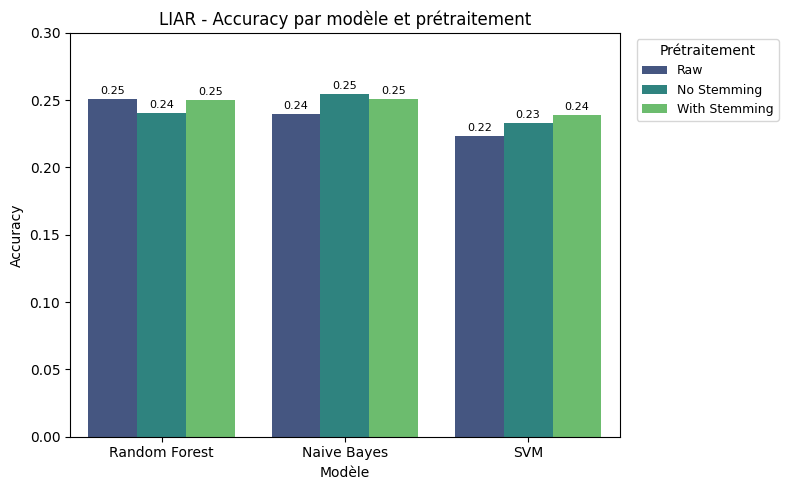

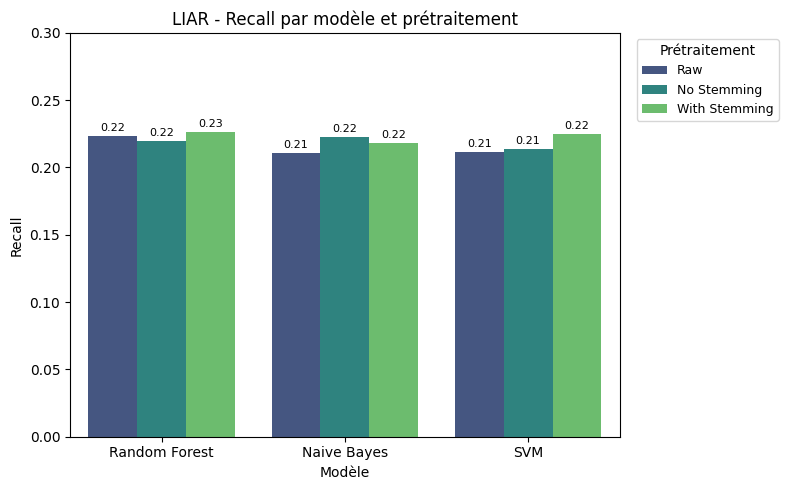

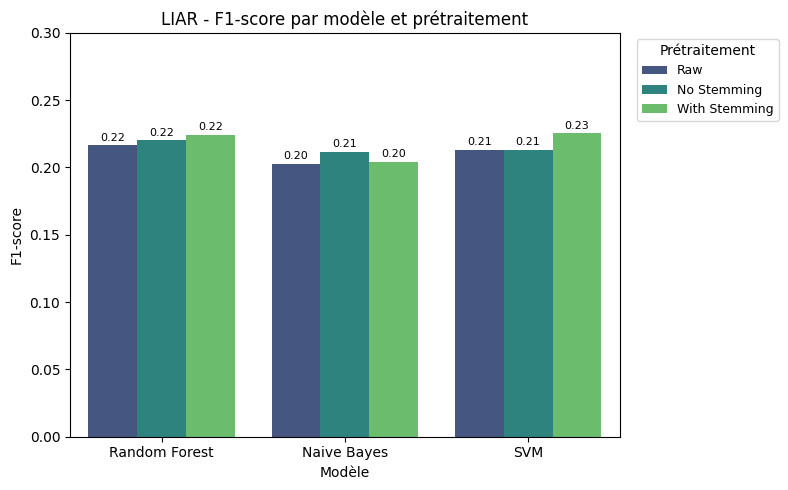

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Résultats LIAR
data = [
    # Random Forest
    ['Random Forest', 'Raw', 0.25099, 0.22338, 0.21646],
    ['Random Forest', 'No Stemming', 0.24073, 0.21948, 0.22019],
    ['Random Forest', 'With Stemming', 0.25020, 0.22632, 0.22406],
    # Naive Bayes
    ['Naive Bayes', 'Raw', 0.23994, 0.21092, 0.20266],
    ['Naive Bayes', 'No Stemming', 0.25493, 0.22255, 0.21175],
    ['Naive Bayes', 'With Stemming', 0.25099, 0.21804, 0.20440],
    # SVM
    ['SVM', 'Raw', 0.22336, 0.21163, 0.21296],
    ['SVM', 'No Stemming', 0.23283, 0.21396, 0.21316],
    ['SVM', 'With Stemming', 0.23915, 0.22480, 0.22539],
]

df = pd.DataFrame(data, columns=['Model', 'Preprocessing', 'Accuracy', 'Recall', 'F1-score'])

metrics = ['Accuracy', 'Recall', 'F1-score']

for metric in metrics:
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(
        data=df,
        x='Model',
        y=metric,
        hue='Preprocessing',
        palette='viridis',
        dodge=True
    )
    plt.title(f'LIAR - {metric} par modèle et prétraitement')
    plt.ylabel(metric)
    plt.ylim(0, 0.3)
    plt.xlabel('Modèle')
    # Move legend outside and reduce font size
    plt.legend(title='Prétraitement', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9, title_fontsize=10)
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", fontsize=8, padding=2)
    plt.tight_layout()
    plt.show()

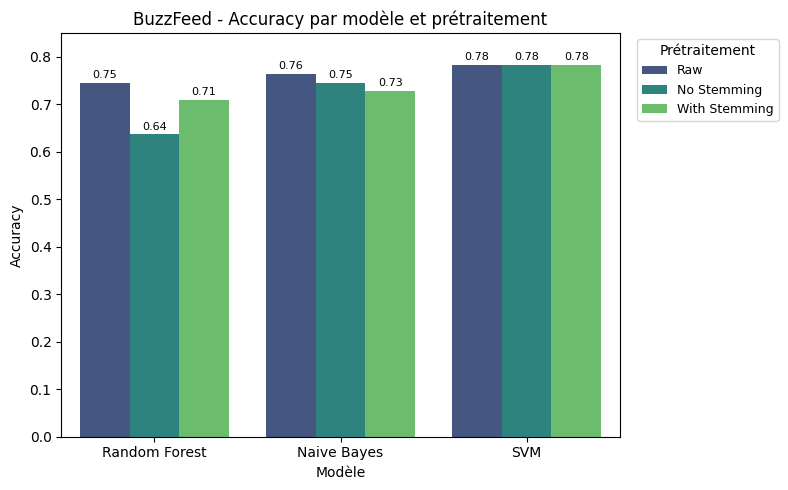

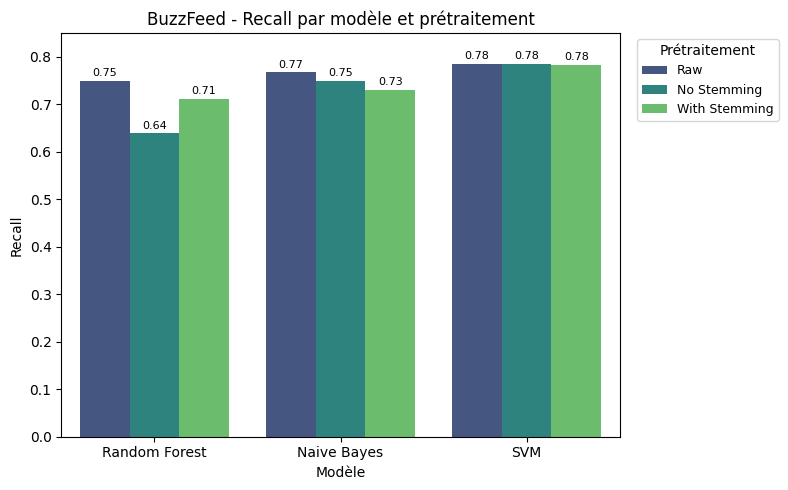

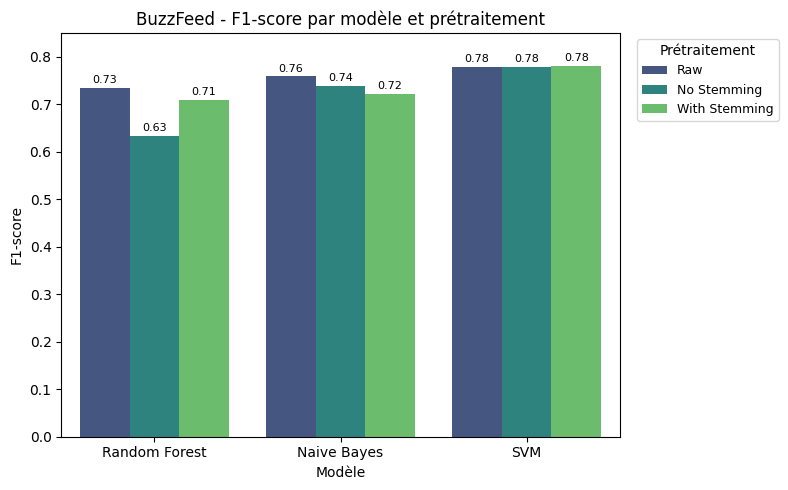

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Résultats BuzzFeed
data_buzz = [
    # Random Forest
    ['Random Forest', 'Raw', 0.74545, 0.74934, 0.73485],
    ['Random Forest', 'No Stemming', 0.63636, 0.63823, 0.63333],
    ['Random Forest', 'With Stemming', 0.70909, 0.71032, 0.70822],
    # Naive Bayes
    ['Naive Bayes', 'Raw', 0.76364, 0.76653, 0.75853],
    ['Naive Bayes', 'No Stemming', 0.74545, 0.74868, 0.73845],
    ['Naive Bayes', 'With Stemming', 0.72727, 0.73016, 0.72138],
    # SVM
    ['SVM', 'Raw', 0.78182, 0.78439, 0.77823],
    ['SVM', 'No Stemming', 0.78182, 0.78439, 0.77823],
    ['SVM', 'With Stemming', 0.78182, 0.78307, 0.78117],
]

df_buzz = pd.DataFrame(data_buzz, columns=['Model', 'Preprocessing', 'Accuracy', 'Recall', 'F1-score'])

metrics = ['Accuracy', 'Recall', 'F1-score']

for metric in metrics:
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(
        data=df_buzz,
        x='Model',
        y=metric,
        hue='Preprocessing',
        palette='viridis',
        dodge=True
    )
    plt.title(f'BuzzFeed - {metric} par modèle et prétraitement')
    plt.ylabel(metric)
    plt.ylim(0, 0.85)
    plt.xlabel('Modèle')
    # Move legend outside and reduce font size
    plt.legend(title='Prétraitement', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9, title_fontsize=10)
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", fontsize=8, padding=2)
    plt.tight_layout()
    plt.show()

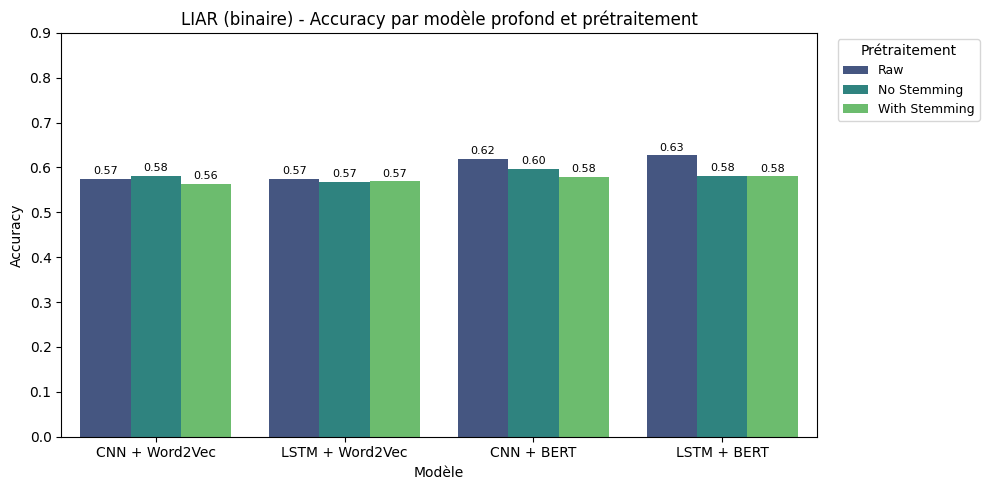

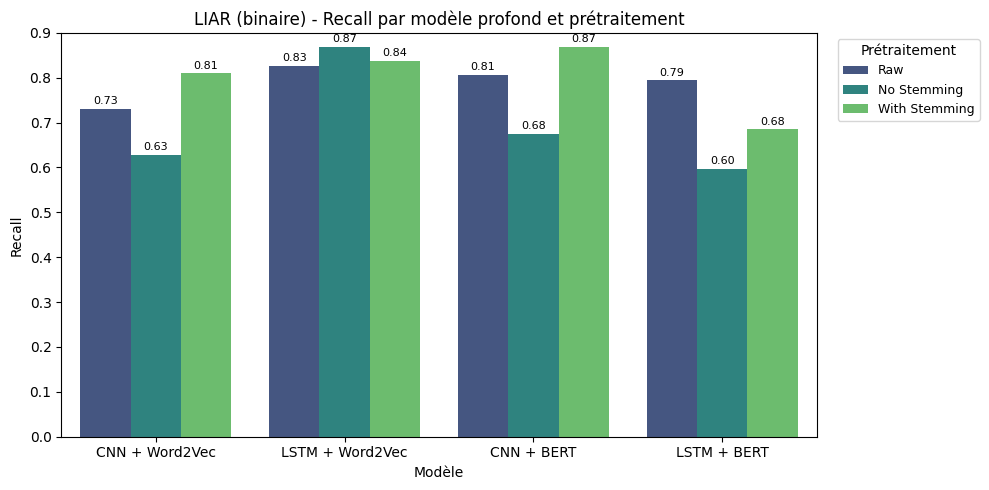

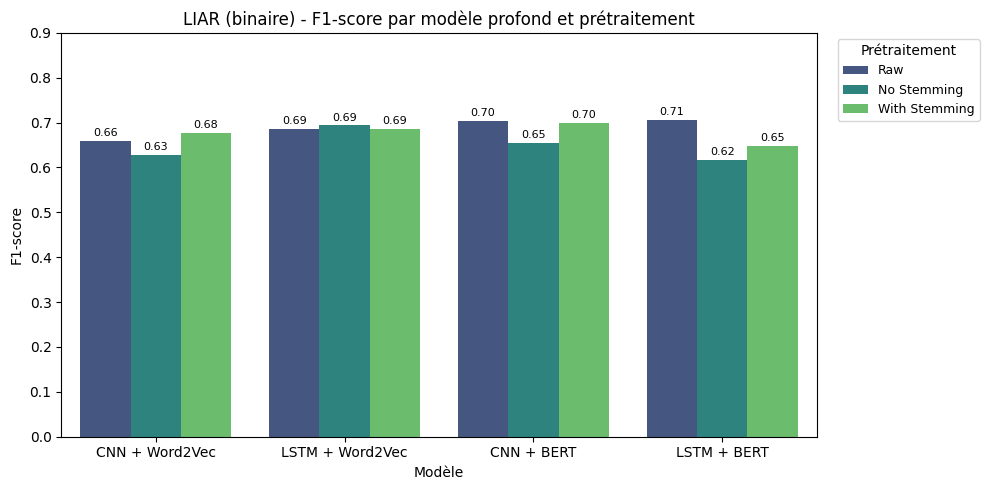

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Résultats LIAR - Deep Learning (Word2Vec et BERT)
data_liar_dl = [
    # CNN + Word2Vec
    ['CNN + Word2Vec', 'Raw', 0.57459, 0.73109, 0.65951],
    ['CNN + Word2Vec', 'No Stemming', 0.58090, 0.62745, 0.62789],
    ['CNN + Word2Vec', 'With Stemming', 0.56354, 0.80952, 0.67642],
    # LSTM + Word2Vec
    ['LSTM + Word2Vec', 'Raw', 0.57380, 0.82633, 0.68605],
    ['LSTM + Word2Vec', 'No Stemming', 0.56748, 0.86835, 0.69351],
    ['LSTM + Word2Vec', 'With Stemming', 0.56906, 0.83754, 0.68657],
    # CNN + BERT
    ['CNN + BERT', 'Raw', 0.61878, 0.80672, 0.70459],
    ['CNN + BERT', 'No Stemming', 0.59747, 0.67507, 0.65400],
    ['CNN + BERT', 'With Stemming', 0.57932, 0.86835, 0.69938],
    # LSTM + BERT
    ['LSTM + BERT', 'Raw', 0.62668, 0.79412, 0.70566],
    ['LSTM + BERT', 'No Stemming', 0.58090, 0.59664, 0.61605],
    ['LSTM + BERT', 'With Stemming', 0.58011, 0.68487, 0.64768],
]

df_liar_dl = pd.DataFrame(data_liar_dl, columns=['Model', 'Preprocessing', 'Accuracy', 'Recall', 'F1-score'])

metrics = ['Accuracy', 'Recall', 'F1-score']

for metric in metrics:
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(
        data=df_liar_dl,
        x='Model',
        y=metric,
        hue='Preprocessing',
        palette='viridis',
        dodge=True
    )
    plt.title(f'LIAR (binaire) - {metric} par modèle profond et prétraitement')
    plt.ylabel(metric)
    plt.ylim(0, 0.9)
    plt.xlabel('Modèle')
    plt.legend(title='Prétraitement', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9, title_fontsize=10)
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", fontsize=8, padding=2)
    plt.tight_layout()
    plt.show()

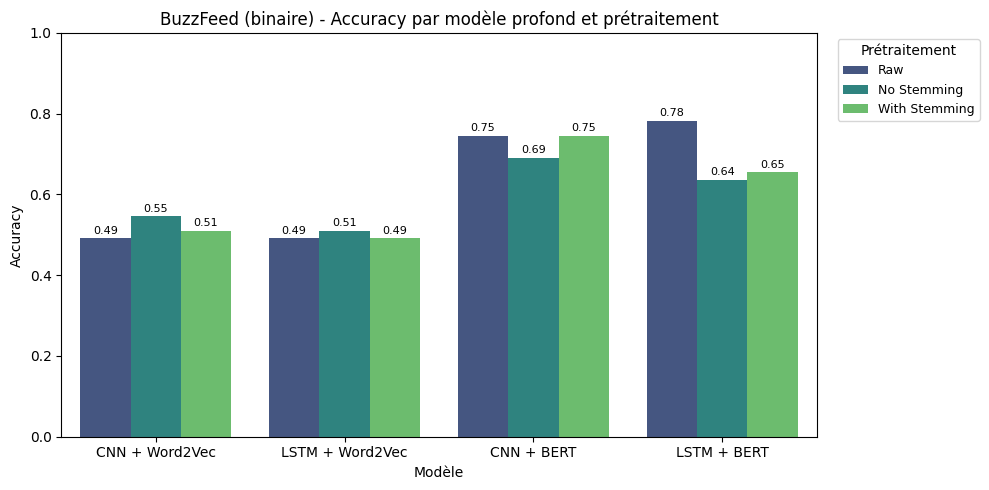

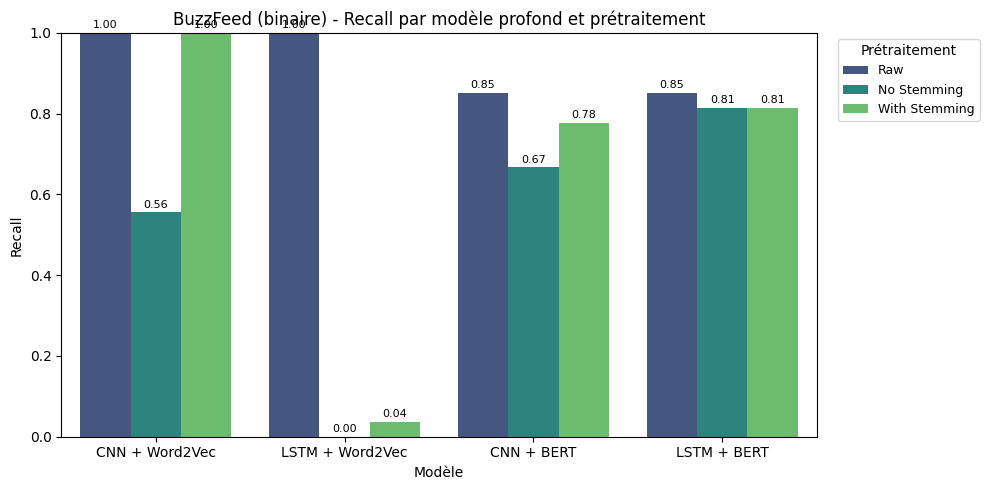

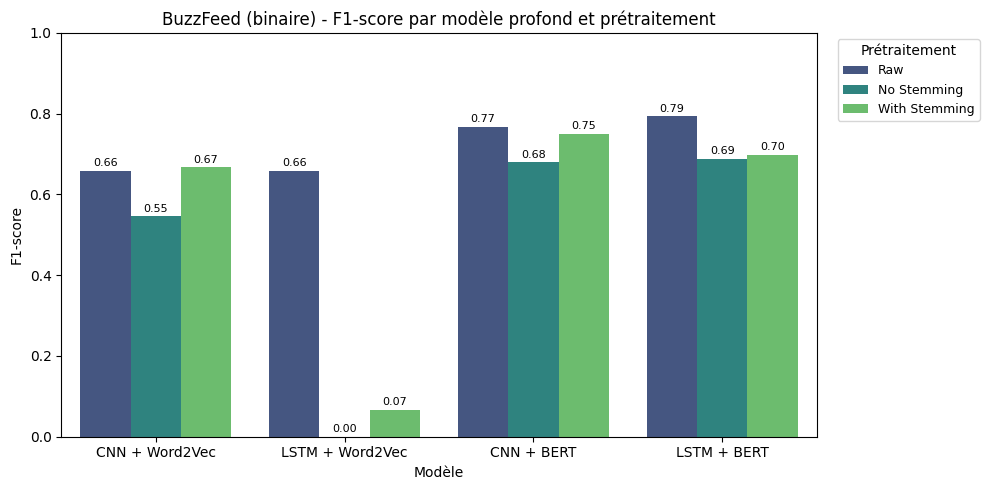

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Résultats BuzzFeed - Deep Learning (Word2Vec et BERT)
data_buzz_dl = [
    # CNN + Word2Vec
    ['CNN + Word2Vec', 'Raw', 0.49091, 1.0, 0.65854],
    ['CNN + Word2Vec', 'No Stemming', 0.54545, 0.55556, 0.54545],
    ['CNN + Word2Vec', 'With Stemming', 0.50909, 1.0, 0.66667],
    # LSTM + Word2Vec
    ['LSTM + Word2Vec', 'Raw', 0.49091, 1.0, 0.65854],
    ['LSTM + Word2Vec', 'No Stemming', 0.50909, 0.0, 0.0],
    ['LSTM + Word2Vec', 'With Stemming', 0.49091, 0.03704, 0.06667],
    # CNN + BERT
    ['CNN + BERT', 'Raw', 0.74545, 0.85185, 0.76667],
    ['CNN + BERT', 'No Stemming', 0.69091, 0.66667, 0.67925],
    ['CNN + BERT', 'With Stemming', 0.74545, 0.77778, 0.75],
    # LSTM + BERT
    ['LSTM + BERT', 'Raw', 0.78182, 0.85185, 0.79310],
    ['LSTM + BERT', 'No Stemming', 0.63636, 0.81481, 0.68750],
    ['LSTM + BERT', 'With Stemming', 0.65455, 0.81481, 0.69841],
]

df_buzz_dl = pd.DataFrame(data_buzz_dl, columns=['Model', 'Preprocessing', 'Accuracy', 'Recall', 'F1-score'])

metrics = ['Accuracy', 'Recall', 'F1-score']

for metric in metrics:
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(
        data=df_buzz_dl,
        x='Model',
        y=metric,
        hue='Preprocessing',
        palette='viridis',
        dodge=True
    )
    plt.title(f'BuzzFeed (binaire) - {metric} par modèle profond et prétraitement')
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.xlabel('Modèle')
    plt.legend(title='Prétraitement', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9, title_fontsize=10)
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", fontsize=8, padding=2)
    plt.tight_layout()
    plt.show()